In [1]:
import json
import os
import pandas as pd
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata.csv"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

mdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
mdatadirectory=mdirectory+"/data/marketdata.csv"

marketdata = pd.read_csv(mdatadirectory)
marketdata = marketdata.replace(np.nan, '', regex=True) 


/opt/homebrew/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fixedRateBondDefinition={}
fixedRateBondDefinition["issueDate"]="2015-03-15"
fixedRateBondDefinition["maturityDate"]="2026-06-04"
fixedRateBondDefinition["frequency"]="Semiannual"
fixedRateBondDefinition["coupon"]=0.085
fixedRateBondDefinition["calendar"]="UnitedStates"
fixedRateBondDefinition["currency"]="TRY"
fixedRateBondDefinition["dateGeneration"]="Backward"
fixedRateBondDefinition["dayCounter"]="Actual360"
fixedRateBondDefinition["businessDayConvention"]="ModifiedFollowing"
fixedRateBondDefinition["maturityDateConvention"]="ModifiedFollowing"
fixedRateBondDefinition["redemption"]=100
fixedRateBondDefinition["endOfMonth"]=True
fixedRateBondDefinition

{'issueDate': '2015-03-15',
 'maturityDate': '2026-06-04',
 'frequency': 'Semiannual',
 'coupon': 0.085,
 'calendar': 'UnitedStates',
 'currency': 'TRY',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'redemption': 100,
 'endOfMonth': True}

In [3]:
instruments={}
depo={}
irs={}

depo["businessDayConvention"]="Following"     # if it is null, default value is used
depo["dayCounter"]="Actual360"                # if it is null, default value is used

irs["businessDayConvention"]="Following"      # if it is null, default value is used 
irs["dayCounter"]="Actual360"                 # if it is null, default value is used 
irs["frequency"]="Semiannual"               

instruments["DEPO"]=depo
instruments["IRS"]=irs

instruments

{'DEPO': {'businessDayConvention': 'Following', 'dayCounter': 'Actual360'},
 'IRS': {'businessDayConvention': 'Following',
  'dayCounter': 'Actual360',
  'frequency': 'Semiannual'}}

In [4]:
# Fix parameters for building yield curve
yieldcurveconfig={
      "name": "TRYZC",
      "settlementDays": 2,
      "intpMethod": "LINEAR",
      "currency": "TRY",
      "calendar": "Turkey",
      "dayCounter": "Actual360",
      "period": "6M",
      "instruments": instruments

    }
yieldcurveconfig

{'name': 'TRYZC',
 'settlementDays': 2,
 'intpMethod': 'LINEAR',
 'currency': 'TRY',
 'calendar': 'Turkey',
 'dayCounter': 'Actual360',
 'period': '6M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'frequency': 'Semiannual'}}}

In [5]:
riskdata = {
  "id": "PORTFOLIO1",
  "name": "PORTFOLIO 1",
  "method": "VaR",
  "forRisk": True,
  "valuationDate": "2021-01-28",
  "valuationCurrency": "TRY",
  "riskMethod": "DELTANORMAL",
  "horizon": 252,
  "confidenceInterval": 0.99,
  "returnType": None,
  "trend": False,
  "calendar": "Turkey",
  "timeBucket": ["0D","1D","1W","2W","3W","1M","2M","3M","6M","9M","1Y","2Y","3Y","4Y",
                "5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"],
  "fillNa": "BACKWARD",
  "maxFillNaDays": 5,
  "tasks": [
            {
      "trade_id": "FRB1000",
      "calculation_type": "fixed_rate_bond",
      "notional": 1000000,
      "settlementDate": "2021-02-01",
      "buySell": "Sell",
      "discountCurve": "TRYZC",
      "fixedRateBondDefinition": fixedRateBondDefinition
    }
  ],
  "curves": [yieldcurveconfig],
  "yieldData": yielddata.to_dict('r'),
  "marketData":marketdata.to_dict('r'),
}

In [6]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
      result=json.loads(res["result"])
    else:
      print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [7]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', result.get('VaR')])
npvTable.add_row(['VAR/PV (%)', result.get('var/pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+---------------+
| Parameters |         Value |
+------------+---------------+
|         PV | -1439540.9774 |
|        VAR |     5222.3096 |
| VAR/PV (%) |        0.3628 |
+------------+---------------+


In [8]:
cashflowForVar=result.get("cashflowForVar")
cashflowForVar=pd.DataFrame(cashflowForVar.get("TRYZC"))

In [9]:
frb=cashflowForVar[['fixingDate', 'accrualStart', 'accrualEnd', 'notional', 'currency',
       'leg', 'payOrReceive', 'instrument', 'rate', 'zeroRate','spread','termToMatByDay', 
        'termToMatByYear', 'cashflow', 'discountFactor','cashflowPv']]
frb

fixingDate accrualStart  accrualEnd  notional currency    leg  \
0   2020-12-02   2020-12-04  2021-06-04   1000000      TRY  Fixed   
1   2021-06-02   2021-06-04  2021-12-06   1000000      TRY  Fixed   
2   2021-12-02   2021-12-06  2022-06-06   1000000      TRY  Fixed   
3   2022-06-02   2022-06-06  2022-12-05   1000000      TRY  Fixed   
4   2022-12-01   2022-12-05  2023-06-05   1000000      TRY  Fixed   
5   2023-06-01   2023-06-05  2023-12-04   1000000      TRY  Fixed   
6   2023-11-30   2023-12-04  2024-06-04   1000000      TRY  Fixed   
7   2024-05-31   2024-06-04  2024-12-04   1000000      TRY  Fixed   
8   2024-12-02   2024-12-04  2025-06-04   1000000      TRY  Fixed   
9   2025-06-02   2025-06-04  2025-12-04   1000000      TRY  Fixed   
10  2025-12-02   2025-12-04  2026-06-04   1000000      TRY  Fixed   
11  2026-06-02   2026-06-04  2026-06-04   1000000      TRY  Fixed   

   payOrReceive       instrument   rate  zeroRate  spread  termToMatByDay  \
0          Sell  Fixed Rate Bond  0.085  0.002171       0             123   
1          Sell  Fixed Rate Bond  0.085  0.002853       0             308   
2          Sell  Fixed Rate Bond  0.085  0.002730       0             490   
3          Sell  Fixed Rate Bond  0.085  0.002170       0             672   
4          Sell  Fixed Rate Bond  0.085  0.002200       0             854   
5          Sell  Fixed Rate Bond  0.085  0.002507       0            1036   
6          Sell  Fixed Rate Bond  0.085  0.003005       0            1219   
7          Sell  Fixed Rate Bond  0.085  0.003593       0            1402   
8          Sell  Fixed Rate Bond  0.085  0.004209       0            1584   
9          Sell  Fixed Rate Bond  0.085  0.004845       0            1767   
10         Sell  Fixed Rate Bond  0.085  0.005523       0            1949   
11         Sell  Fixed Rate Bond  0.085  0.005523       0            1949   

    termToMatByYear        cashflow  discountFactor     cashflowPv  
0          0.341667   -42972.222222        0.999259  -42940.362135  
1          0.855556   -43680.555556        0.997562  -43574.053902  
2          1.361111   -42972.222222        0.996291  -42812.835421  
3          1.866667   -42972.222222        0.995958  -42798.543198  
4          2.372222   -42972.222222        0.994794  -42748.514889  
5          2.877778   -42972.222222        0.992810  -42663.255503  
6          3.386111   -43208.333333        0.989875  -42770.854902  
7          3.894444   -43208.333333        0.986104  -42607.909578  
8          4.400000   -42972.222222        0.981650  -42183.671227  
9          4.908333   -43208.333333        0.976501  -42192.998076  
10         5.413889   -42972.222222        0.970542  -41706.331340  
11         5.413889 -1000000.000000        0.970542 -970541.647223

In [10]:
cashflowForVar[['binLTimeToMatByDay', 'binRTimeToMatByDay', 'binL','binR', 'stDevL', 'stDevR', 'correl',
                'vertixL', 'vertixR','splitFactor', 'yieldsL', 'yieldsR', 'yields','stdev', 'duration',
                'cashflows0', 'cashflowsL', 'cashflowsR', 'presentValue', 'splitPv','splitDuration']]

binLTimeToMatByDay  binRTimeToMatByDay binL binR    stDevL    stDevR  \
0                   90                 181   3M   6M  0.045911  0.034505   
1                  273                 365   9M   1Y  0.029362  0.029077   
2                  365                 732   1Y   2Y  0.029077  0.051946   
3                  365                 732   1Y   2Y  0.029077  0.051946   
4                  732                1096   2Y   3Y  0.051946  0.057739   
5                  732                1096   2Y   3Y  0.051946  0.057739   
6                 1096                1461   3Y   4Y  0.057739  0.065762   
7                 1096                1461   3Y   4Y  0.057739  0.065762   
8                 1461                1826   4Y   5Y  0.065762  0.062450   
9                 1461                1826   4Y   5Y  0.065762  0.062450   
10                1826                2191   5Y   6Y  0.062450  0.065998   
11                1826                2191   5Y   6Y  0.062450  0.065998   

      correl  vertixL  vertixR  splitFactor  ...   yieldsR    yields  \
0   0.596626  TRYZC3M  TRYZC6M     0.476982  ...  0.002275  0.002173   
1   0.931134  TRYZC9M  TRYZC1Y     0.092161  ...  0.003115  0.002853   
2   0.201254  TRYZC1Y  TRYZC2Y     0.358435  ...  0.001991  0.002732   
3   0.201254  TRYZC1Y  TRYZC2Y     0.082352  ...  0.001991  0.002175   
4   0.881757  TRYZC2Y  TRYZC3Y     0.396759  ...  0.002607  0.002197   
5   0.881757  TRYZC2Y  TRYZC3Y     0.083058  ...  0.002607  0.002505   
6   0.907809  TRYZC3Y  TRYZC4Y     0.484837  ...  0.003789  0.003005   
7   0.907809  TRYZC3Y  TRYZC4Y     0.100628  ...  0.003789  0.003598   
8   0.940251  TRYZC4Y  TRYZC5Y     0.672930  ...  0.005053  0.004215   
9   0.940251  TRYZC4Y  TRYZC5Y     0.296990  ...  0.005053  0.004849   
10  0.948721  TRYZC5Y  TRYZC6Y     0.434452  ...  0.006455  0.005526   
11  0.948721  TRYZC5Y  TRYZC6Y     0.434452  ...  0.006455  0.005526   

       stdev      duration    cashflows0     cashflowsL     cashflowsR  \
0   0.041775  1.467128e+04    -78.131524  -27698.975424  -15195.494518   
1   0.029253  3.728002e+04  -5662.739223   -4539.926347  -33486.242973   
2   0.036866  5.827286e+04  -3774.944327  -20666.104069  -18511.415349   
3   0.048207  7.988985e+04   -155.905571   -6509.514676  -36299.489679   
4   0.053888  1.014097e+05  -2794.628500  -19922.301863  -20272.255283   
5   0.056784  1.227761e+05   -622.457694   -5049.261800  -37306.784824   
6   0.060442  1.448268e+05  -1326.551181  -23268.958605  -18644.020429   
7   0.064465  1.659310e+05   -395.689049   -5533.214795  -37291.744171   
8   0.064646  1.856034e+05    512.684385  -31210.560971  -12272.349349   
9   0.062986  2.070932e+05   1629.664354  -15369.266103  -29432.580720   
10  0.063646  2.257903e+05  -1395.255230  -19831.169875  -21822.141809   
11  0.063646  5.254332e+06 -32468.770715 -461488.116035 -507819.718893   

     presentValue        splitPv  splitDuration  
0   -42940.336298  -42940.336298   1.467128e+04  
1   -43574.053902  -43574.053902   3.728002e+04  
2   -42812.713165  -42812.713165   5.827286e+04  
3   -42798.131550  -42798.131550   7.988985e+04  
4   -42748.799871  -42748.799871   1.014097e+05  
5   -42663.496907  -42663.496907   1.227761e+05  
6   -42770.849803  -42770.849803   1.448268e+05  
7   -42607.102033  -42607.102033   1.659310e+05  
8   -42182.599525  -42182.599525   1.856034e+05  
9   -42192.162800  -42192.162800   2.070932e+05  
10  -41705.754554  -41705.754554   2.257903e+05  
11 -970528.224912 -970528.224912   5.254332e+06  

[12 rows x 21 columns]

In [11]:
mappedcf=cashflowForVar[['termToMatByDay','cashflow',"binLTimeToMatByDay","binRTimeToMatByDay",'cashflows0', 'cashflowsL', 'cashflowsR', 'presentValue', 'splitPv',"duration",'splitDuration']]
mappedcf

termToMatByDay        cashflow  binLTimeToMatByDay  binRTimeToMatByDay  \
0              123   -42972.222222                  90                 181   
1              308   -43680.555556                 273                 365   
2              490   -42972.222222                 365                 732   
3              672   -42972.222222                 365                 732   
4              854   -42972.222222                 732                1096   
5             1036   -42972.222222                 732                1096   
6             1219   -43208.333333                1096                1461   
7             1402   -43208.333333                1096                1461   
8             1584   -42972.222222                1461                1826   
9             1767   -43208.333333                1461                1826   
10            1949   -42972.222222                1826                2191   
11            1949 -1000000.000000                1826                2191   

      cashflows0     cashflowsL     cashflowsR   presentValue        splitPv  \
0     -78.131524  -27698.975424  -15195.494518  -42940.336298  -42940.336298   
1   -5662.739223   -4539.926347  -33486.242973  -43574.053902  -43574.053902   
2   -3774.944327  -20666.104069  -18511.415349  -42812.713165  -42812.713165   
3    -155.905571   -6509.514676  -36299.489679  -42798.131550  -42798.131550   
4   -2794.628500  -19922.301863  -20272.255283  -42748.799871  -42748.799871   
5    -622.457694   -5049.261800  -37306.784824  -42663.496907  -42663.496907   
6   -1326.551181  -23268.958605  -18644.020429  -42770.849803  -42770.849803   
7    -395.689049   -5533.214795  -37291.744171  -42607.102033  -42607.102033   
8     512.684385  -31210.560971  -12272.349349  -42182.599525  -42182.599525   
9    1629.664354  -15369.266103  -29432.580720  -42192.162800  -42192.162800   
10  -1395.255230  -19831.169875  -21822.141809  -41705.754554  -41705.754554   
11 -32468.770715 -461488.116035 -507819.718893 -970528.224912 -970528.224912   

        duration  splitDuration  
0   1.467128e+04   1.467128e+04  
1   3.728002e+04   3.728002e+04  
2   5.827286e+04   5.827286e+04  
3   7.988985e+04   7.988985e+04  
4   1.014097e+05   1.014097e+05  
5   1.227761e+05   1.227761e+05  
6   1.448268e+05   1.448268e+05  
7   1.659310e+05   1.659310e+05  
8   1.856034e+05   1.856034e+05  
9   2.070932e+05   2.070932e+05  
10  2.257903e+05   2.257903e+05  
11  5.254332e+06   5.254332e+06

In [12]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['Split PV', cashflowForVar["splitPv"].sum()])
npvTable.add_row(['Errror', 100*(result.get('pv')-cashflowForVar["splitPv"].sum())/result.get('pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)
print("PV is preserved")

+------------+---------------+
| Parameters |         Value |
+------------+---------------+
|         PV | -1439540.9774 |
|   Split PV | -1439524.2253 |
|     Errror |        0.0012 |
+------------+---------------+
PV is preserved


In [13]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['Duration', cashflowForVar["duration"].sum()])
npvTable.add_row(['Split Duration', cashflowForVar["splitDuration"].sum()])
npvTable.add_row(['Errror', 100*(cashflowForVar["duration"].sum()-cashflowForVar["splitDuration"].sum())/cashflowForVar["duration"].sum()])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)
print("Duration is preserved")

+----------------+--------------+
|     Parameters |        Value |
+----------------+--------------+
|       Duration | 6597876.4999 |
| Split Duration | 6597876.4999 |
|         Errror |       0.0000 |
+----------------+--------------+
Duration is preserved


In [14]:
original_cf=pd.DataFrame(cashflowForVar['cashflow'].values,index=cashflowForVar['termToMatByDay'].tolist()).reset_index()
original_cf.columns=["bin","cashflows"]
original_cf=original_cf.groupby('bin').sum()
original_cf=original_cf.reset_index()


In [15]:
leftcf=cashflowForVar[["binLTimeToMatByDay","cashflowsL"]]
leftcf.columns=["bin","cashflows"]
rightcf=cashflowForVar[["binRTimeToMatByDay","cashflowsR"]]
rightcf.columns=["bin","cashflows"]
mappedcf=pd.concat([leftcf,rightcf])
mappedcf=mappedcf.groupby('bin').sum()
mappedcf=mappedcf.reset_index()


In [16]:
mappedcf0=cashflowForVar["cashflows0"].sum()
mappedcf["Cashflows"]="mapped cashflows"
original_cf["Cashflows"]="original cashflows"
cf=pd.concat([original_cf,mappedcf])
cf.loc[len(cf.index)] = [0,mappedcf0,"mapped cashflows0"] 
cf

bin     cashflows           Cashflows
0    123 -4.297222e+04  original cashflows
1    308 -4.368056e+04  original cashflows
2    490 -4.297222e+04  original cashflows
3    672 -4.297222e+04  original cashflows
4    854 -4.297222e+04  original cashflows
5   1036 -4.297222e+04  original cashflows
6   1219 -4.320833e+04  original cashflows
7   1402 -4.320833e+04  original cashflows
8   1584 -4.297222e+04  original cashflows
9   1767 -4.320833e+04  original cashflows
10  1949 -1.042972e+06  original cashflows
0     90 -2.769898e+04    mapped cashflows
1    181 -1.519549e+04    mapped cashflows
2    273 -4.539926e+03    mapped cashflows
3    365 -6.066186e+04    mapped cashflows
4    732 -7.978247e+04    mapped cashflows
5   1096 -8.638121e+04    mapped cashflows
6   1461 -1.025156e+05    mapped cashflows
7   1826 -5.230242e+05    mapped cashflows
8   2191 -5.296419e+05    mapped cashflows
20     0 -4.653272e+04   mapped cashflows0

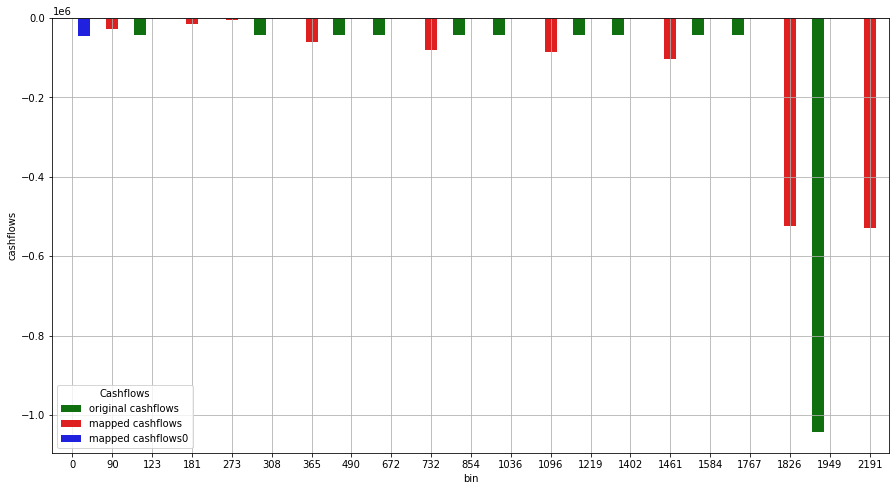

In [17]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x="bin",y="cashflows",data=cf,hue="Cashflows",width=0.9,palette=["green", "red","blue"])
ax.grid()

In [20]:
portfoliocorr=result.get("riskFactorsCorr")
pd.DataFrame(portfoliocorr)

TRYZC0D   TRYZC1D   TRYZC1W   TRYZC2W   TRYZC3W   TRYZC1M  \
TRYZC0D   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
TRYZC1D   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
TRYZC1W   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
TRYZC2W   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
TRYZC3W   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
TRYZC1M   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
TRYZC2M   0.691755  0.691755  0.691755  0.691755  0.691755  0.691755   
TRYZC3M   0.563094  0.563094  0.563094  0.563094  0.563094  0.563094   
TRYZC6M   0.503333  0.503333  0.503333  0.503333  0.503333  0.503333   
TRYZC9M   0.543372  0.543372  0.543372  0.543372  0.543372  0.543372   
TRYZC1Y   0.508069  0.508069  0.508069  0.508069  0.508069  0.508069   
TRYZC2Y   0.330010  0.330010  0.330010  0.330010  0.330010  0.330010   
TRYZC3Y   0.159995  0.159995  0.159995  0.159995  0.159995  0.159995   
TRYZC4Y   0.236830  0.236830  0.236830  0.236830  0.236830  0.236830   
TRYZC5Y   0.238875  0.238875  0.238875  0.238875  0.238875  0.238875   
TRYZC6Y   0.185311  0.185311  0.185311  0.185311  0.185311  0.185311   
TRYZC7Y   0.194558  0.194558  0.194558  0.194558  0.194558  0.194558   
TRYZC8Y   0.195936  0.195936  0.195936  0.195936  0.195936  0.195936   
TRYZC9Y   0.204695  0.204695  0.204695  0.204695  0.204695  0.204695   
TRYZC10Y  0.255008  0.255008  0.255008  0.255008  0.255008  0.255008   
TRYZC12Y  0.261205  0.261205  0.261205  0.261205  0.261205  0.261205   
TRYZC15Y  0.238894  0.238894  0.238894  0.238894  0.238894  0.238894   
TRYZC20Y  0.246247  0.246247  0.246247  0.246247  0.246247  0.246247   
TRYZC25Y  0.234173  0.234173  0.234173  0.234173  0.234173  0.234173   
TRYZC30Y  0.290357  0.290357  0.290357  0.290357  0.290357  0.290357   
TRYZC40Y  0.267326  0.267326  0.267326  0.267326  0.267326  0.267326   
TRYZC50Y  0.234319  0.234319  0.234319  0.234319  0.234319  0.234319   

           TRYZC2M   TRYZC3M   TRYZC6M   TRYZC9M  ...   TRYZC8Y   TRYZC9Y  \
TRYZC0D   0.691755  0.563094  0.503333  0.543372  ...  0.195936  0.204695   
TRYZC1D   0.691755  0.563094  0.503333  0.543372  ...  0.195936  0.204695   
TRYZC1W   0.691755  0.563094  0.503333  0.543372  ...  0.195936  0.204695   
TRYZC2W   0.691755  0.563094  0.503333  0.543372  ...  0.195936  0.204695   
TRYZC3W   0.691755  0.563094  0.503333  0.543372  ...  0.195936  0.204695   
TRYZC1M   0.691755  0.563094  0.503333  0.543372  ...  0.195936  0.204695   
TRYZC2M   1.000000  0.661129  0.546814  0.606043  ...  0.213672  0.226003   
TRYZC3M   0.661129  1.000000  0.596626  0.630402  ...  0.128450  0.141817   
TRYZC6M   0.546814  0.596626  1.000000  0.923736  ...  0.158446  0.179902   
TRYZC9M   0.606043  0.630402  0.923736  1.000000  ...  0.166485  0.193191   
TRYZC1Y   0.585826  0.585988  0.728293  0.931134  ...  0.151500  0.180567   
TRYZC2Y   0.310602  0.276923  0.239804  0.236185  ...  0.740924  0.723081   
TRYZC3Y   0.211253  0.154983  0.161708  0.152399  ...  0.814602  0.791656   
TRYZC4Y   0.236976  0.141934  0.154218  0.150853  ...  0.923856  0.907520   
TRYZC5Y   0.224231  0.135913  0.183678  0.184116  ...  0.924321  0.911275   
TRYZC6Y   0.187756  0.117790  0.143770  0.148556  ...  0.982885  0.970600   
TRYZC7Y   0.198112  0.106424  0.151321  0.153089  ...  0.968265  0.953558   
TRYZC8Y   0.213672  0.128450  0.158446  0.166485  ...  1.000000  0.993399   
TRYZC9Y   0.226003  0.141817  0.179902  0.193191  ...  0.993399  1.000000   
TRYZC10Y  0.253081  0.152673  0.227436  0.232536  ...  0.951028  0.960913   
TRYZC12Y  0.248765  0.158080  0.197655  0.204874  ...  0.961522  0.969738   
TRYZC15Y  0.242510  0.155367  0.208182  0.228971  ...  0.931233  0.949829   
TRYZC20Y  0.259471  0.170653  0.228275  0.250858  ...  0.908718  0.930201   
TRYZC25Y  0.247552  0.167664  0.219192  0.241200  ...  0.873315  0.906226   
TRYZC30Y  0.291342  0.193558  0.268292  0.289878  ...  0.876192  0.89

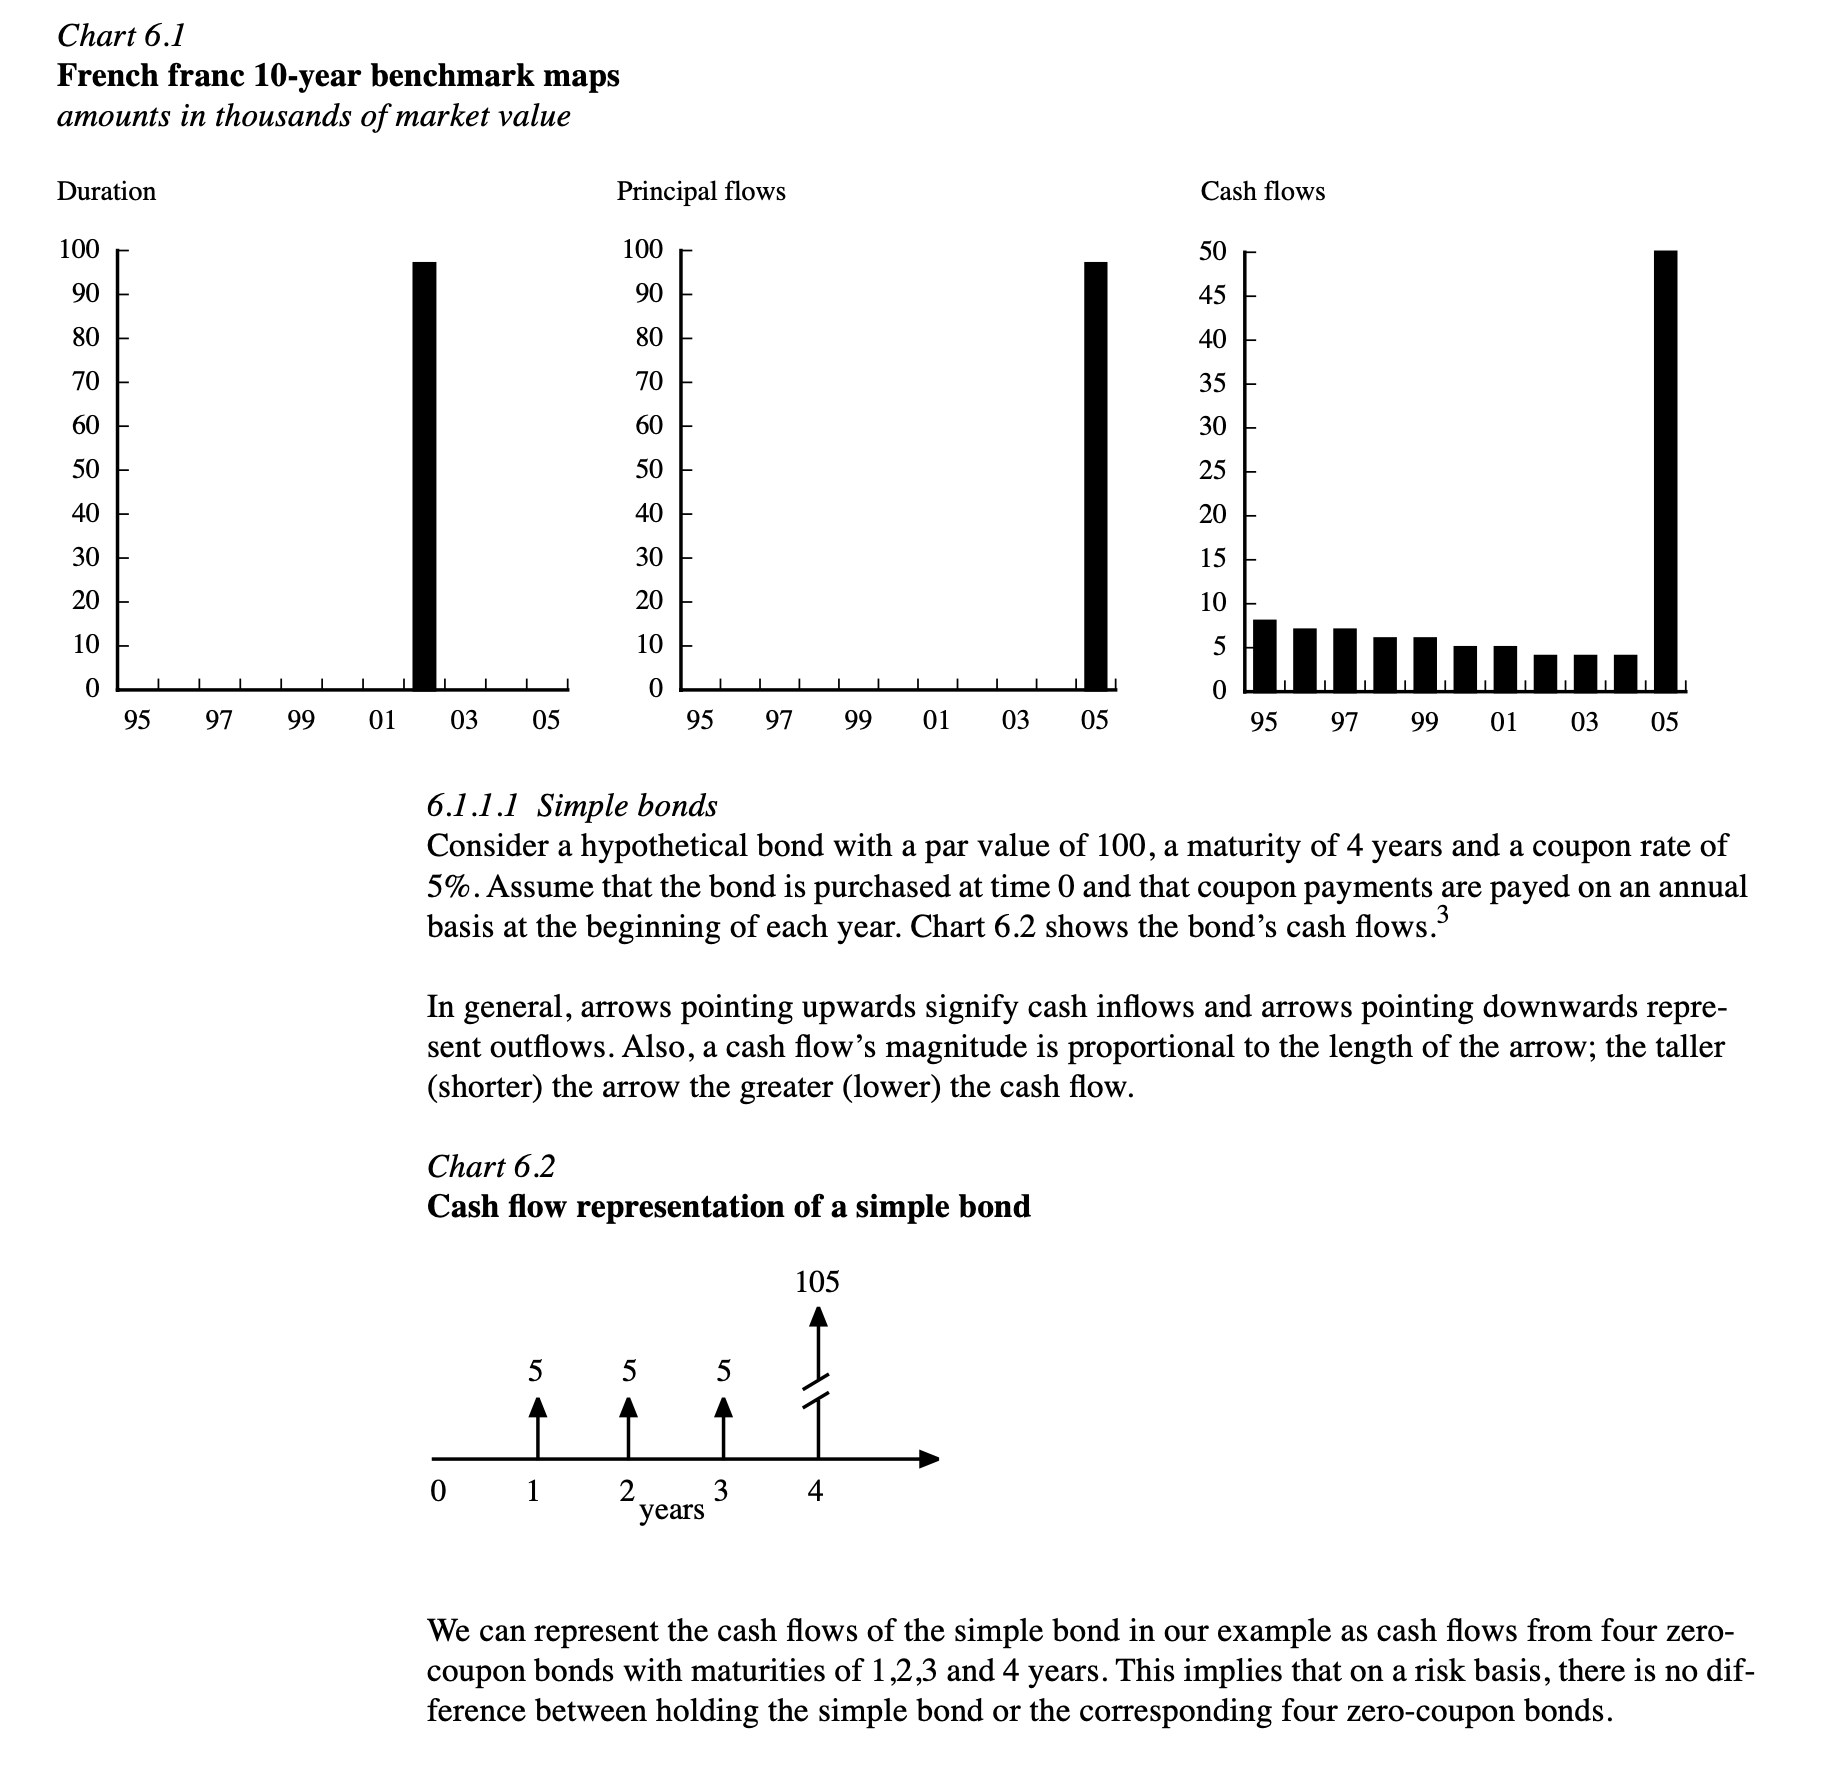

In [ ]:
# https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a (Page 109)

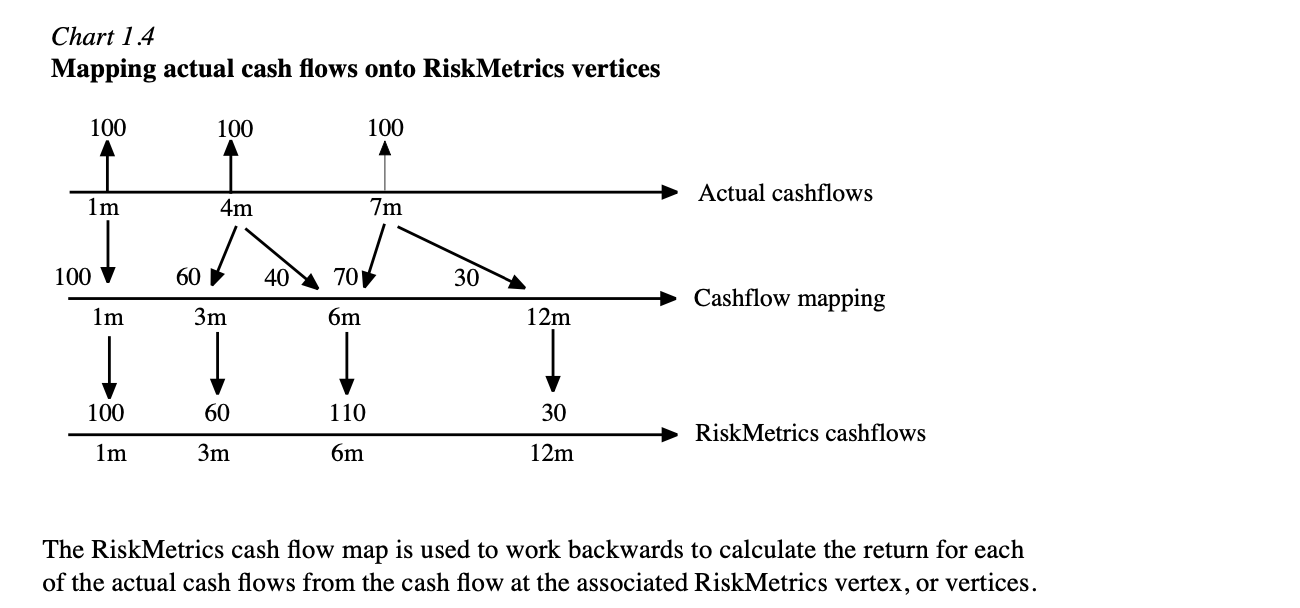

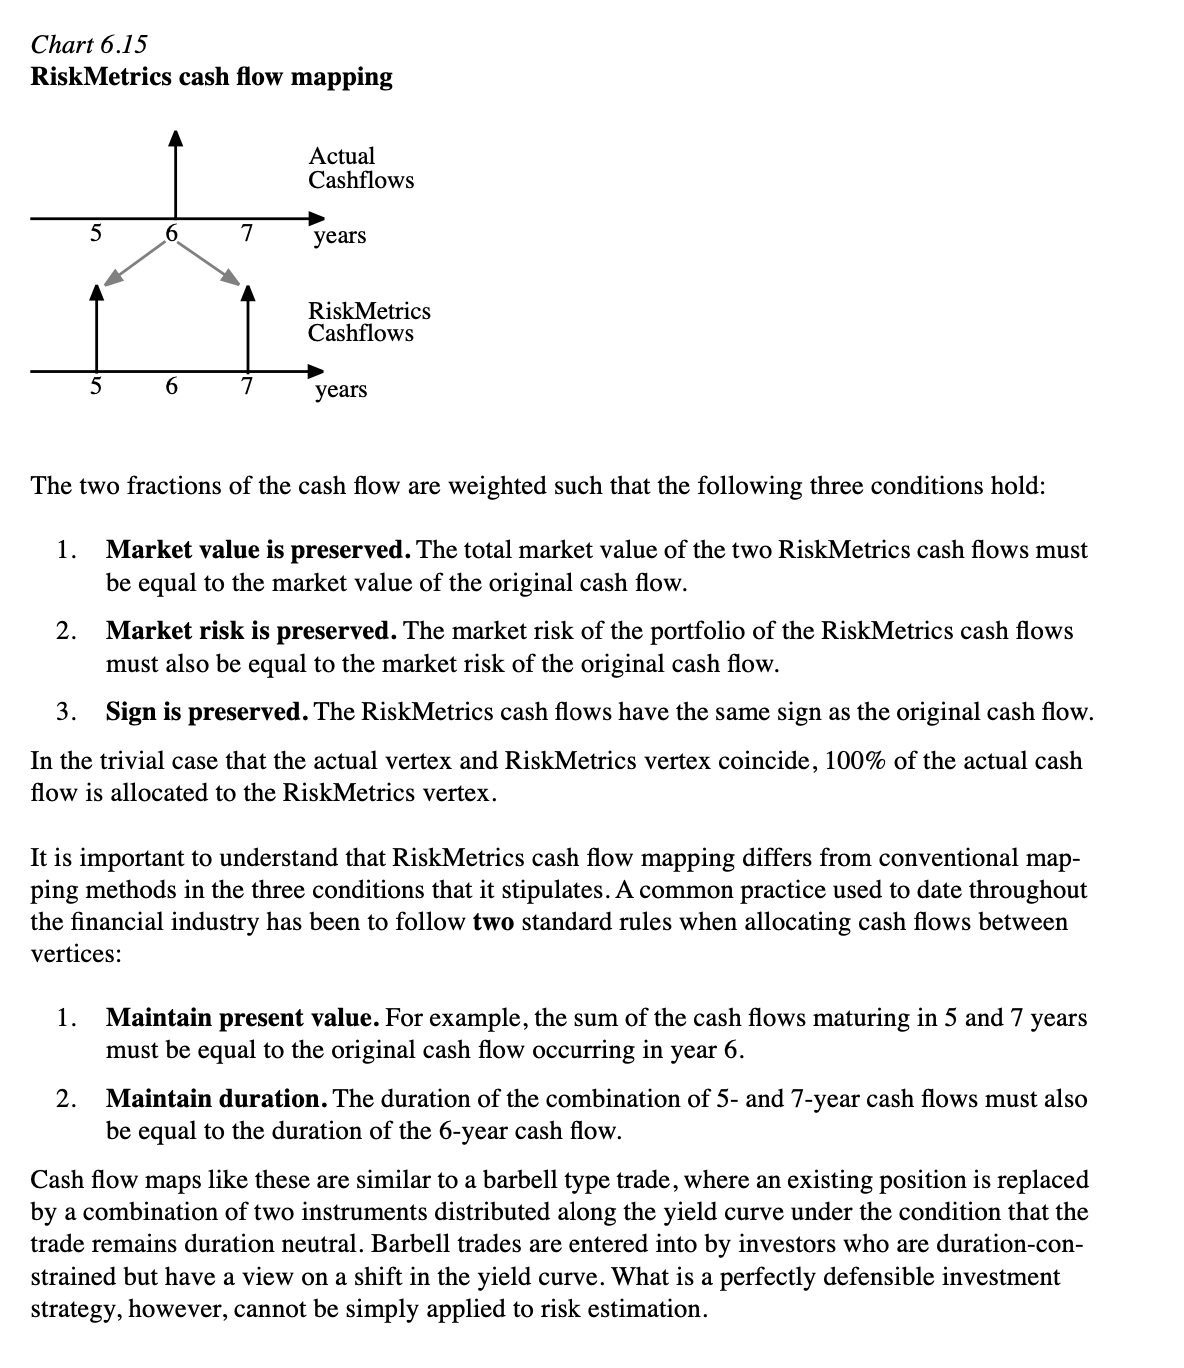

In [ ]:
# https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a (Page 118)

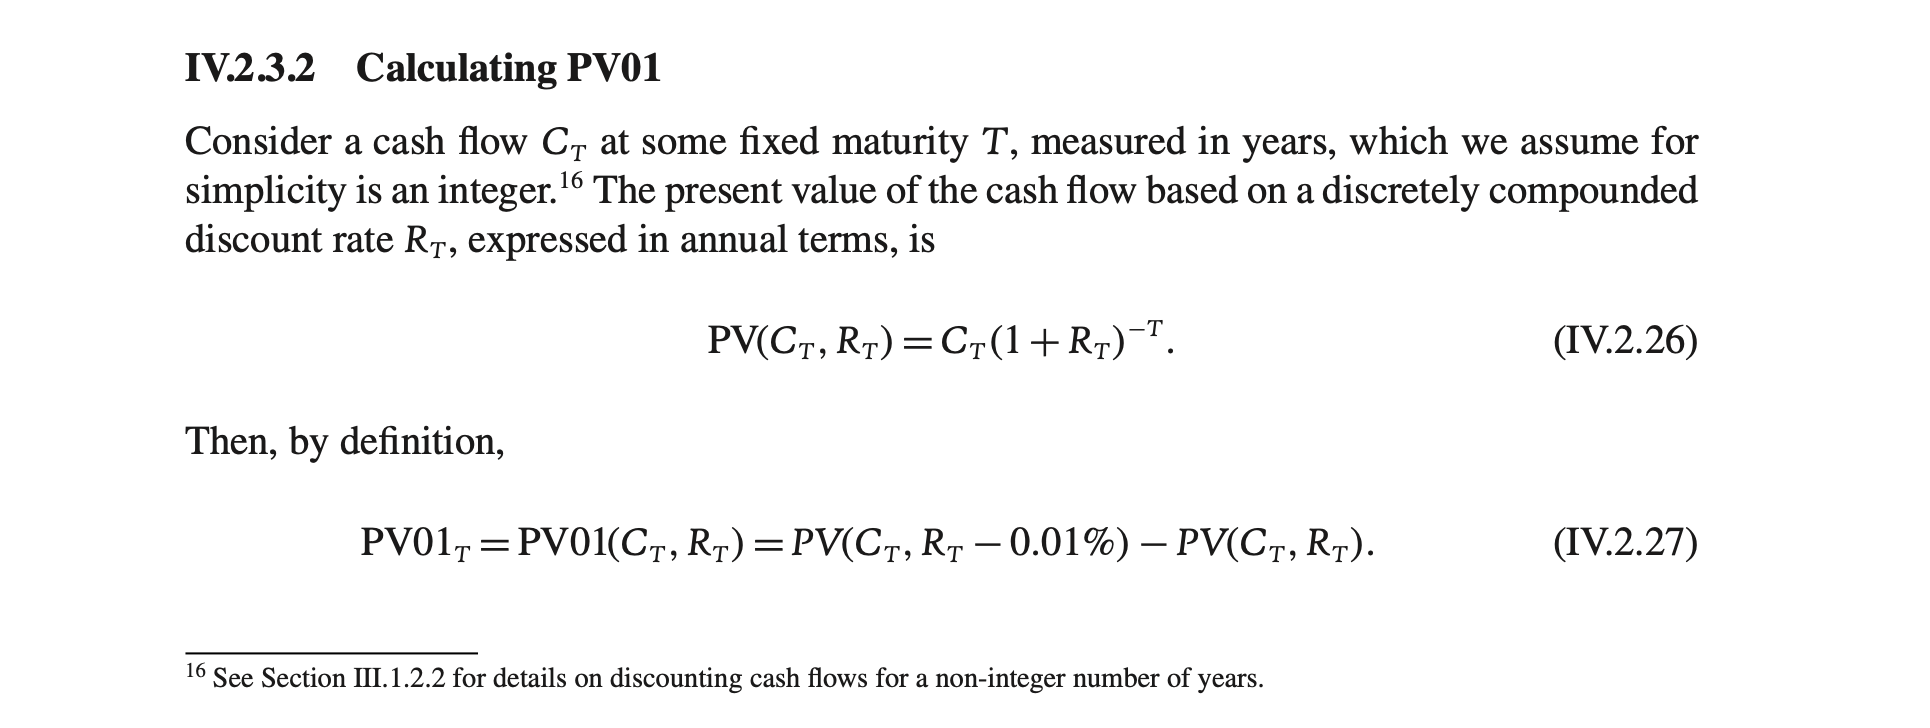

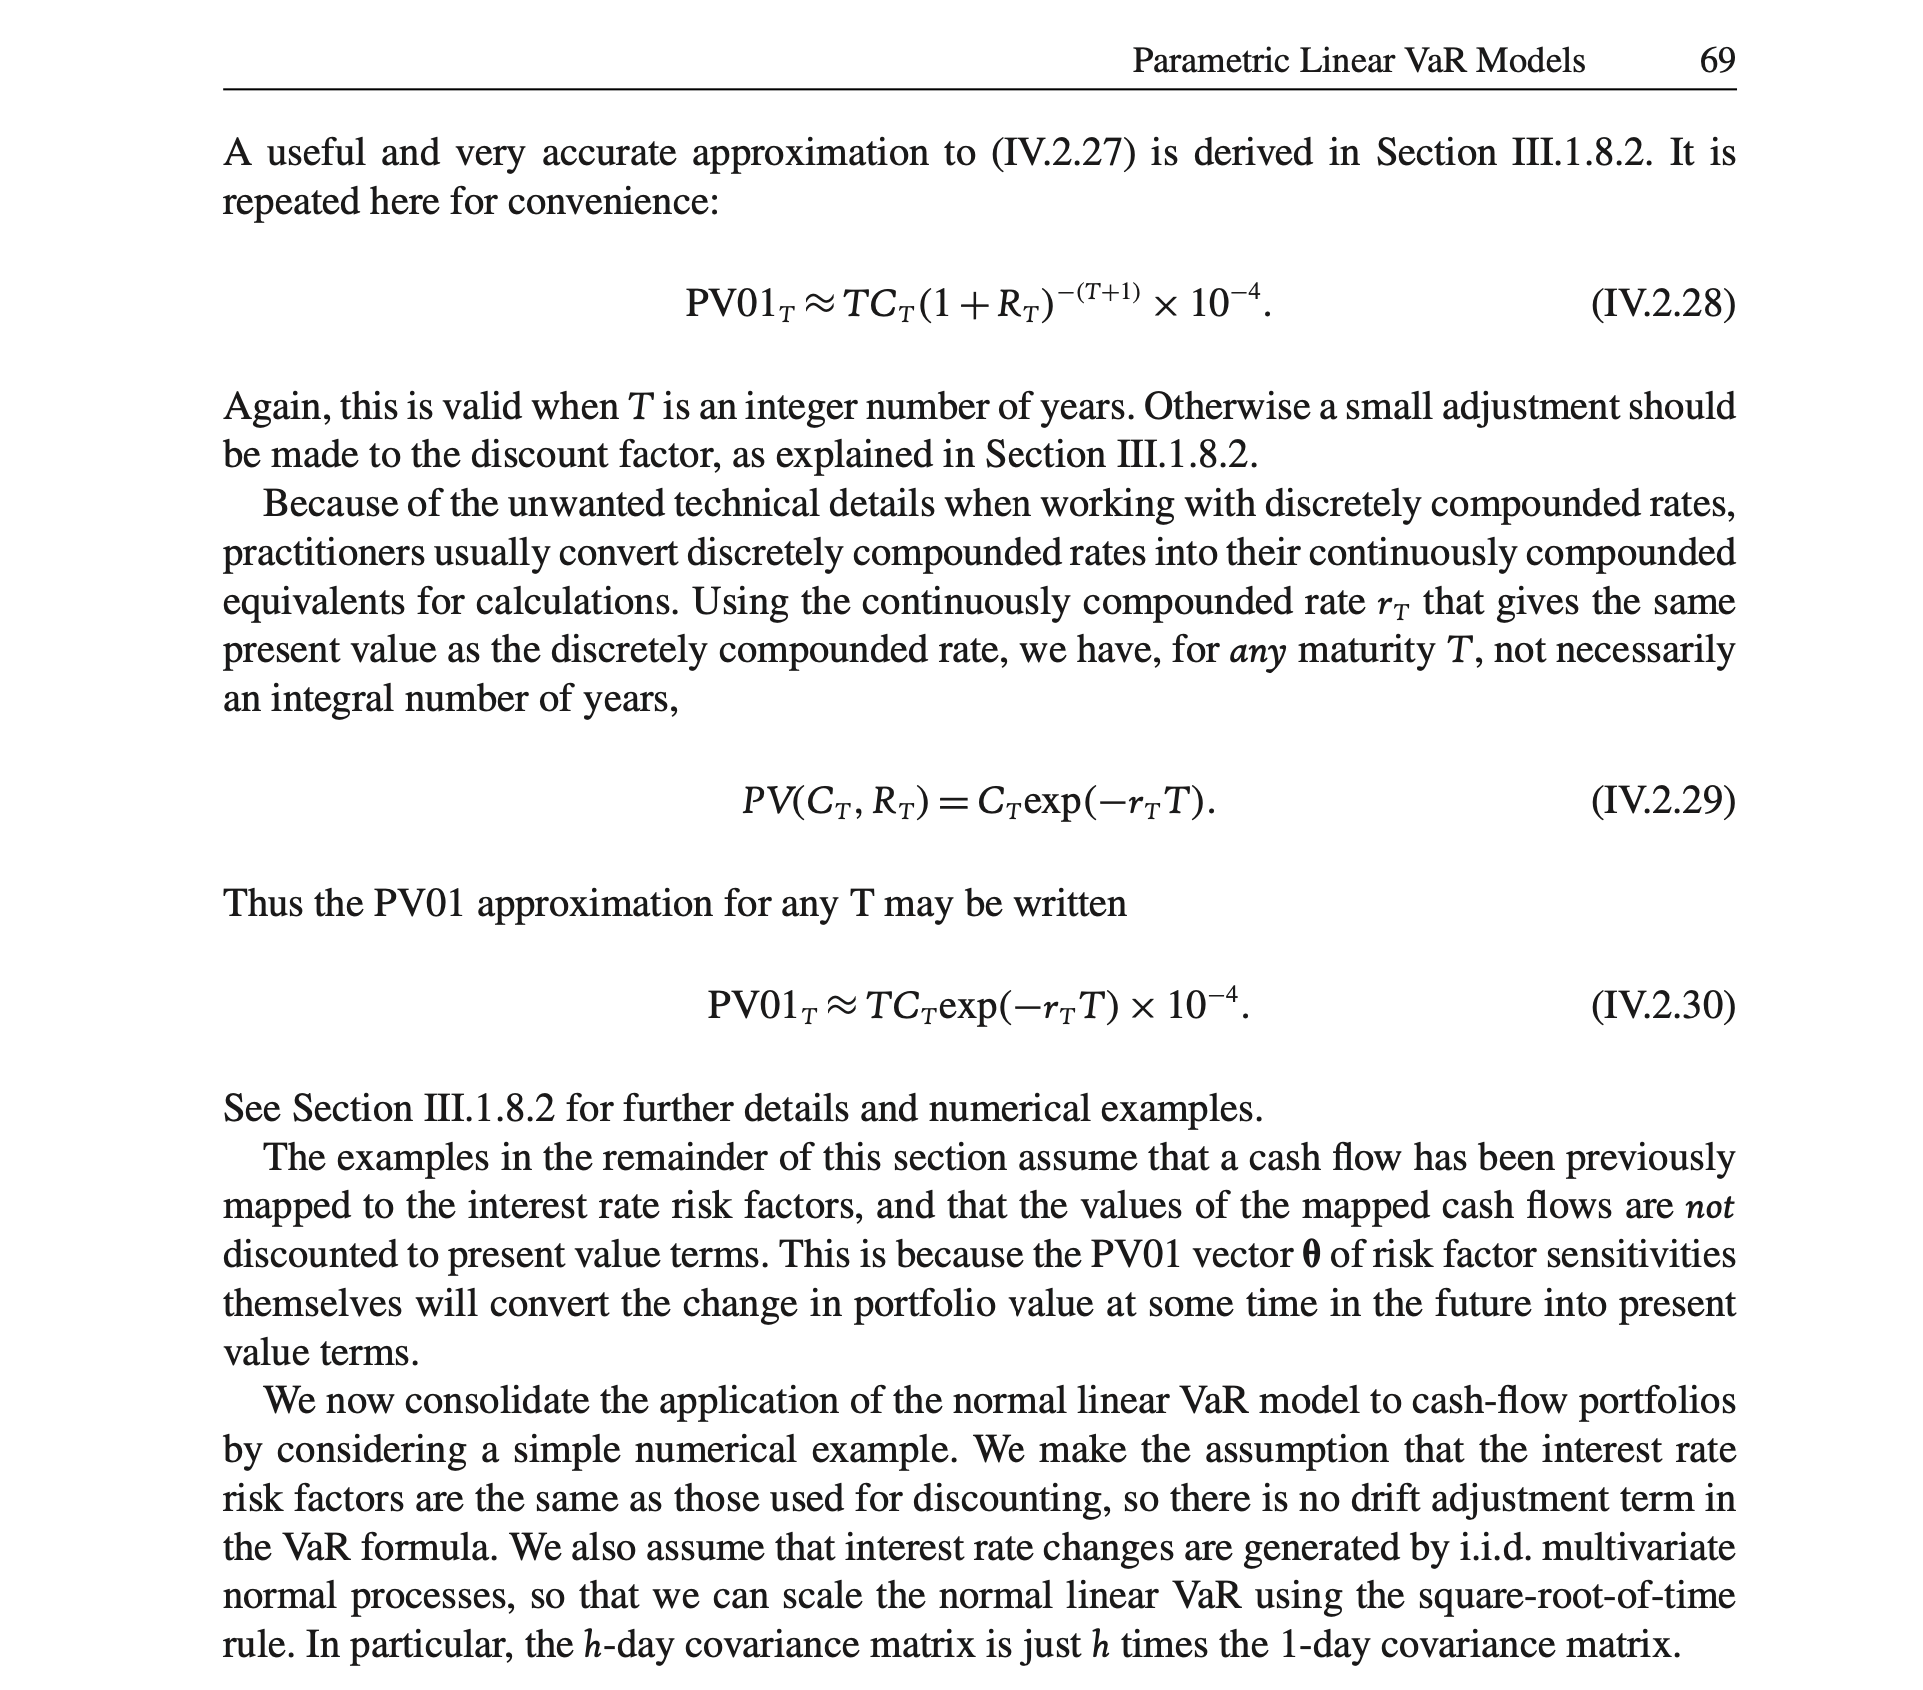

In [ ]:
# Market Risk Analysis Volume IV
#Value-at-Risk Models
#Carol Alexander
#Page (68)